In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

In [2]:
class resNet(nn.Module) :
    def __init__(self, nin, nout) :
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.Layer1 = nn.Linear(nin, 15)
        self.Layer2 = nn.Linear(15, 15)
        self.Layer3 = nn.Linear(15, nout)

    def forward(self, tX) :
        x = self.Layer1(tX)
        x = torch.relu(x)
        x = self.Layer2(x)
        x = torch.relu(x)
        x = self.Layer3(x)
        return x
    
    def zero_grad(self, set_to_none: bool = False) -> None:
        return super().zero_grad(set_to_none)
    
    def set_params(self, param_list):
        for p1, p2 in zip(list(self.parameters()), param_list) :
            p1.data = p2
        return self

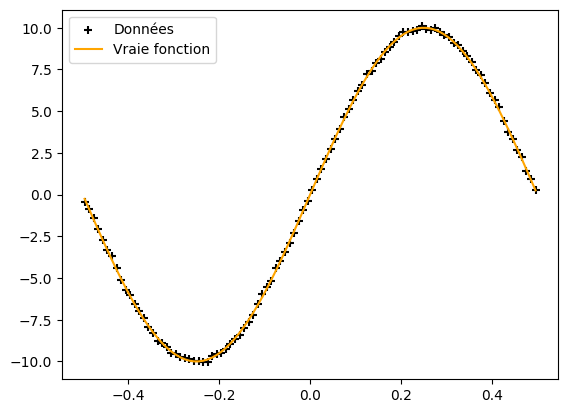

In [3]:
# Definition de la fonction de test
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10*np.sin(2*np.pi*x) + epsilon

# Paramétrage des données d'entrainements
train_size = 100
noise = 0.1
# Pour sin
xmin = -0.5
xmax = 0.5

zoomfig = 2
xminBig = xmin - zoomfig * (xmax - xmin)
xmaxBig = xmax + zoomfig * (xmax - xmin)

XBig = np.linspace(xminBig, xmaxBig, train_size * (2 * zoomfig + 1)).reshape(-1, 1)
X = XBig[train_size * zoomfig : train_size * zoomfig + train_size]
# X = np.linspace(-np.pi, np.pi, train_size).reshape(-1, 1)


y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

# On affiche tout ça
plt.scatter(X, y, marker='+', label='Données', color = 'k')
plt.plot(X, y_true, label='Vraie fonction', color = 'orange')
plt.legend()
plt.show()

In [4]:
tX = torch.Tensor(X)
tXBig = torch.Tensor(XBig)
ty = torch.Tensor(y)

print("tX.shape : ", tX.shape)
print("tXBig.shape : ", tXBig.shape)
print("ty.shape : ", ty.shape)

tX.shape :  torch.Size([100, 1])
tXBig.shape :  torch.Size([500, 1])
ty.shape :  torch.Size([100, 1])


In [5]:
# Hypperparamètres
N = 20000
ns = [1, 15, 15, 1]
nbParams = 2 * (len(ns) - 1)

In [6]:
thetas = []
for idxList in range(N) : 
    idxParam = 0

    param = []
    for idxParam in range(nbParams) :
        f = open("../data_prepare/sinParams/{}_{}.pt".format(idxList, idxParam), "rb")
        param.append(torch.load(f))
        f.close()
    
    thetas.append(param)

In [7]:
myModel = resNet(1, 1)

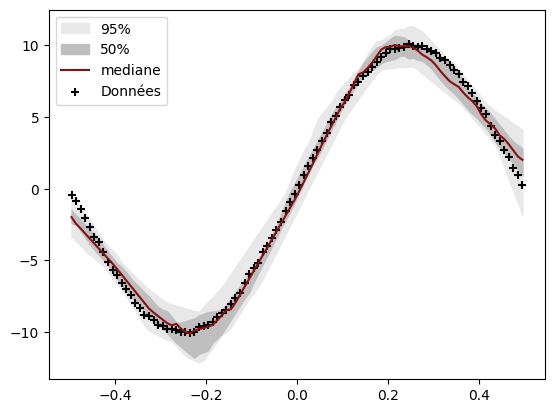

In [8]:
y_hats = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tX) for theta in thetas]), 1)


q2_5 = y_hats.quantile(0.025, 1).reshape(-1,1).detach().numpy()
q97_5 = y_hats.quantile(0.975, 1).reshape(-1,1).detach().numpy()
q25 = y_hats.quantile(0.25, 1).reshape(-1,1).detach().numpy()
q75 = y_hats.quantile(0.75, 1).reshape(-1,1).detach().numpy()
med = y_hats.quantile(0.5, 1).reshape(-1,1).detach().numpy()

plt.clf()


plt.fill_between(tX.ravel().numpy(), q2_5[:, 0],
                 q97_5[:, 0], color="#e8e8e8", label='95%')

plt.fill_between(tX.ravel().numpy(), q25[:, 0], q75[:, 0],
                 color="#bfbfbf", label='50%')

plt.plot(tX, med, label="mediane", color="#8c0e11")

plt.scatter(tX,ty, marker='+', color='k', label='Données')

plt.legend()
plt.show()


In [9]:
thetaRavel = torch.concatenate(tuple([torch.concatenate(tuple([p.ravel() for p in theta])).reshape(-1,1) for theta in thetas]), 1)

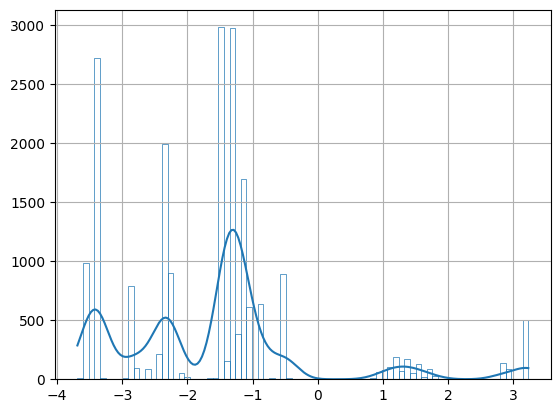

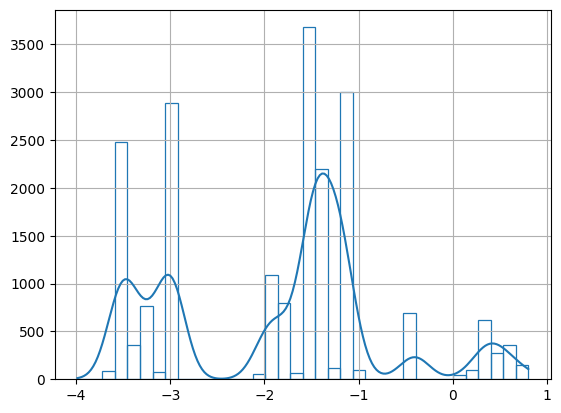

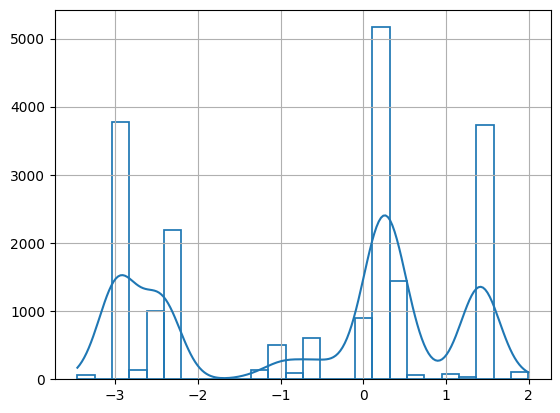

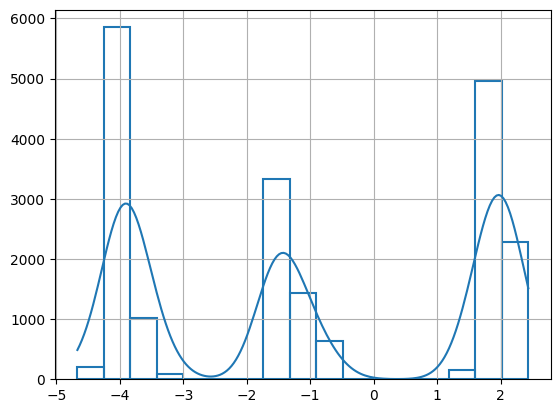

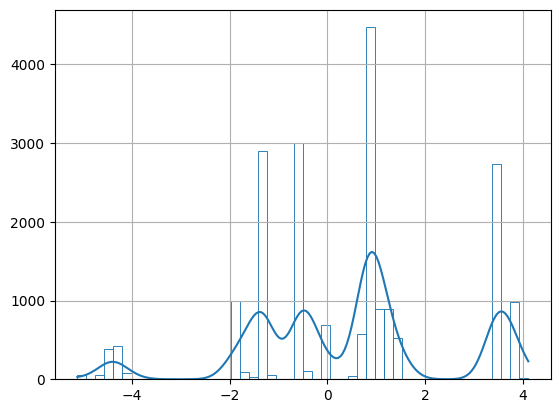

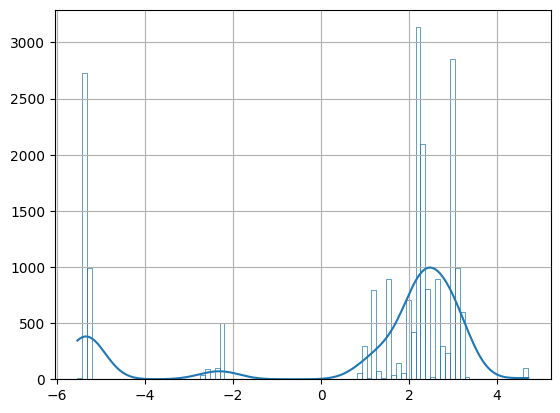

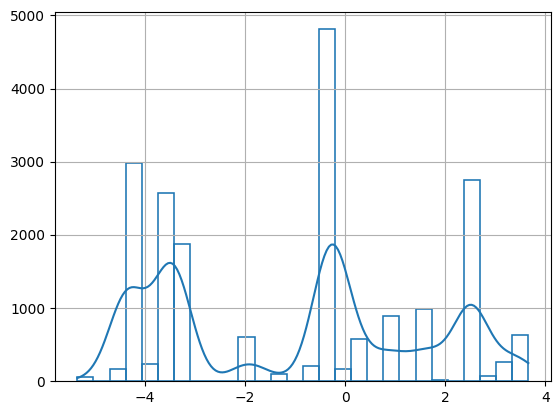

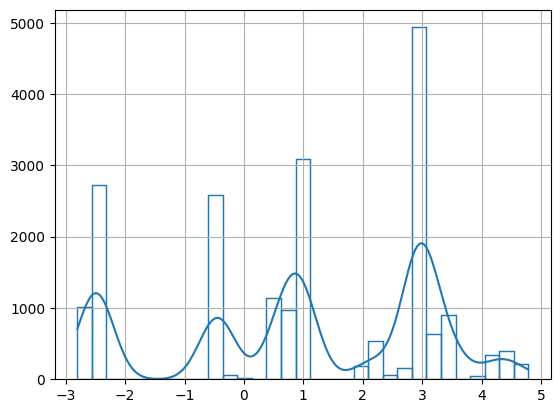

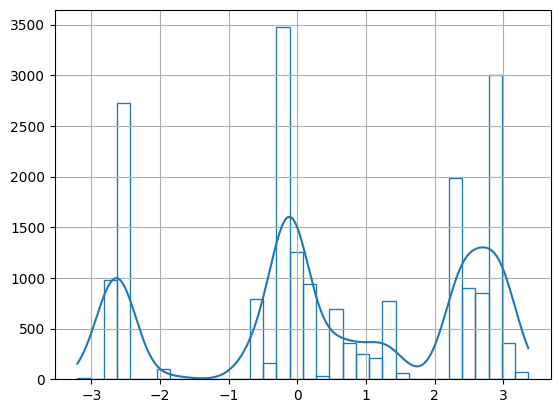

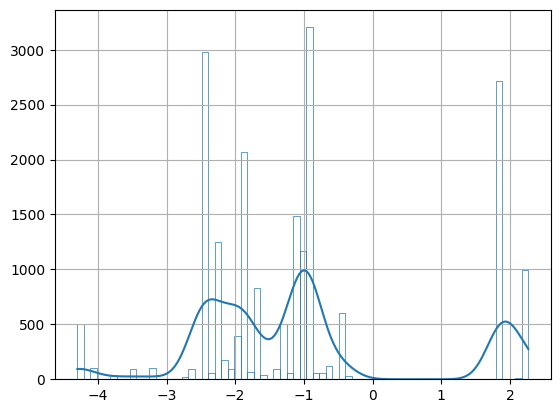

In [13]:
for k in range(10) :
    plt.figure()
    sns.histplot(thetaRavel[k,:].detach().numpy(), kde = True, fill = False)
    plt.grid('on')
    plt.ylabel(None)

<Figure size 640x480 with 0 Axes>

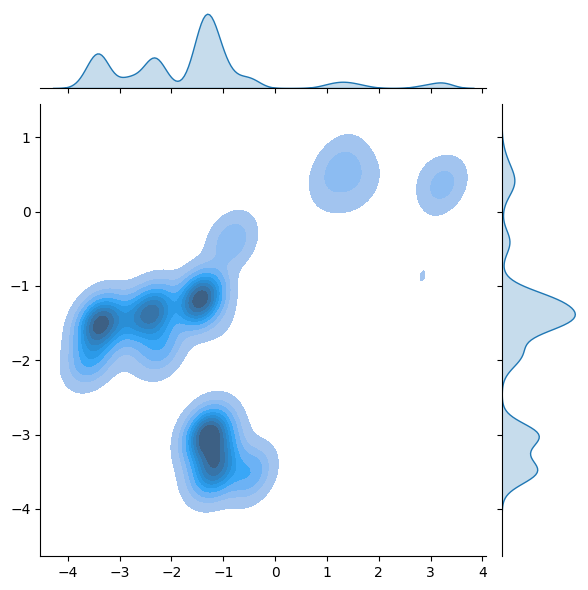

In [10]:
plt.figure()
s = 0
d = 1
sns.jointplot(x = thetaRavel[s,:].detach().numpy(), y = thetaRavel[d,:].detach().numpy(), kind='kde', fill=True)
plt.show()

In [11]:
y_hats = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tXBig) for theta in thetas]), 1)


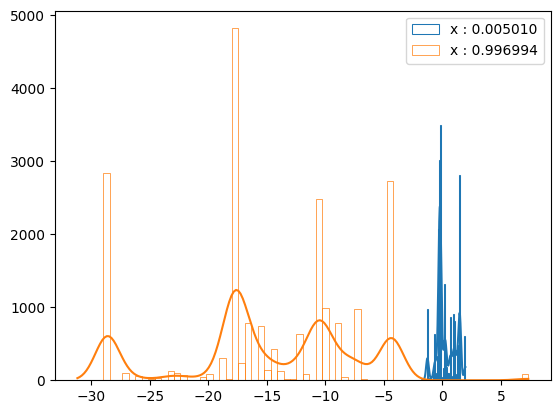

In [12]:
middle = torch.argmin(torch.abs(tXBig))
left = middle + 100
sns.histplot(y_hats[middle + 1,:].detach().numpy(), kde = True, label = 'x : {:2f}'.format(tXBig[middle+1][0]), fill = None)
sns.histplot(y_hats[left,:].detach().numpy(), kde = True, label = 'x : {:2f}'.format(tXBig[left][0]), fill = None)
plt.ylabel(None)
plt.legend()